<a href="https://colab.research.google.com/github/adarsh-kumar-shah/Heart_Health_Analysis/blob/main/googleplaystore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/googleplaystore.csv")

In [7]:
df.shape

(10841, 13)

In [8]:
# dropping coruppted data
df.drop(df[df['Category'] == '1.9'].index, inplace=True)

In [12]:
# handling missing value
rating_median = df['Rating'].median()
df.loc[:, 'Rating'] = df['Rating'].fillna(rating_median)

In [14]:
df.dropna(subset=['Type', 'Content Rating', 'Current Ver', 'Android Ver'], inplace=True)


In [16]:
# converting Data Types and Standardize data
df['Reviews'] = pd.to_numeric(df['Reviews'])
df['Installs'] = df['Installs'].str.replace('+', '', regex=False)
df['Installs'] = df['Installs'].str.replace(',', '', regex=False)
df['Installs'] = pd.to_numeric(df['Installs'])
df['Price'] = df['Price'].str.replace('$', '', regex=False)
df['Price'] = pd.to_numeric(df['Price'])

In [18]:
# size conversion
def clean_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
        elif 'Varies with device' in size:
            return np.nan
    return size

df['Size'] = df['Size'].apply(clean_size)

size_median = df['Size'].median()

df.loc[:, 'Size'] = df['Size'].fillna(size_median)

df['Last Updated'] = pd.to_datetime(df['Last Updated'])

In [19]:
# removing duplicate
df.sort_values(by='Reviews', ascending=False, inplace=True)
df.drop_duplicates(subset=['App'], keep='first', inplace=True)

In [22]:
df.shape

(9648, 13)

**Basic Level Question**
1. Average rating

In [23]:
df['Rating'].mean()

np.float64(4.192485489220564)

2. Unique categories

In [24]:
df['Category'].nunique()

33

3. Distribution of app sizes

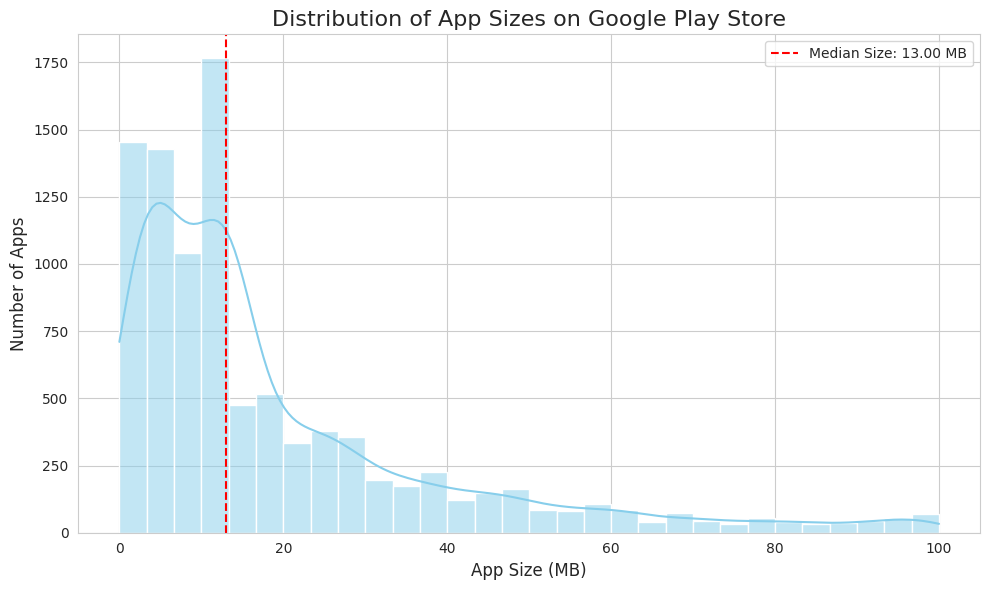

The median app size is: 13.00 MB


In [25]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(df['Size'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of App Sizes on Google Play Store', fontsize=16)
plt.xlabel('App Size (MB)', fontsize=12)
plt.ylabel('Number of Apps', fontsize=12)

median_size = df['Size'].median()
plt.axvline(median_size, color='red', linestyle='--', label=f'Median Size: {median_size:.2f} MB')

plt.legend()
plt.tight_layout()
plt.show()

print(f"The median app size is: {median_size:.2f} MB")

4. Free vs paid apps

In [26]:
df['Type'].value_counts()

,count
Type,
Free,8897
Paid,751


5. Most common content rating

In [27]:
df['Content Rating'].mode()[0]

'Everyone'

6. Top 5 most installed apps

In [28]:
top_installed_apps = df.sort_values(by='Installs', ascending=False)

result = top_installed_apps[['App', 'Category', 'Installs', 'Rating']].head(5)

print(result)

                                App       Category    Installs  Rating
2544                       Facebook         SOCIAL  1000000000     4.1
5856              Google Play Games         FAMILY  1000000000     4.3
391   Skype - free IM & video calls  COMMUNICATION  1000000000     4.1
1872                 Subway Surfers           GAME  1000000000     4.5
3665                        YouTube  VIDEO_PLAYERS  1000000000     4.3


7. Apps with rating $\ge 4.0$

In [29]:
df[df['Rating'] >= 4.0].shape[0]

7740

8. Avg. reviews for free vs paid

In [30]:
df.groupby('Type')['Reviews'].mean()

,Reviews
Type,
Free,234628.577161
Paid,8782.410120


9. Average app size per category

In [31]:
df.groupby('Category')['Size'].mean()

,Size
Category,
ART_AND_DESIGN,12.421667
AUTO_AND_VEHICLES,19.208948
BEAUTY,13.705660
BOOKS_AND_REFERENCE,13.173595
BUSINESS,13.776074
COMICS,13.695149
COMMUNICATION,11.698813
DATING,15.528927
EDUCATION,17.083397


10. Apps last updated in 2018

In [33]:
apps2018 = df[df['Last Updated'].dt.year == 2018]

count2018 = apps2018.shape[0]

print(f"Total number of apps last updated in 2018: {count2018}")

Total number of apps last updated in 2018: 6282


**Medium Level Question**
1. Correlation between Installs and Rating

In [34]:
df['Installs_Log'] = np.log1p(df['Installs'])
correlation = df[['Installs_Log', 'Rating']].corr().iloc[0, 1]
print(f"Pearson Correlation: {correlation:.4f}")

Pearson Correlation: 0.0114


2. App categories with the highest average rating

In [39]:
avgrating = df.groupby('Category')['Rating'].mean().sort_values(ascending=False).head(5)
print(avgrating.to_string())

Category
EVENTS                 4.395313
ART_AND_DESIGN         4.376667
EDUCATION              4.348571
BOOKS_AND_REFERENCE    4.334389
PERSONALIZATION        4.324866


3. How app price affects its average rating

In [40]:
df_paid = df[df['Type'] == 'Paid'].copy()
price_bins = [0, 1, 5, 10, 50, 400]
price_labels = ['Free/Sub-$1', '$1-$5', '$5-$10', '$10-$50', '$50+']
df_paid.loc[:, 'Price_Bin'] = pd.cut(df_paid['Price'], bins=price_bins, labels=price_labels, right=False)

avgprice = df_paid.groupby('Price_Bin', observed=True)['Rating'].mean().sort_values(ascending=False)
print(avgprice.to_string())

Price_Bin
Free/Sub-$1    4.300699
$1-$5          4.276000
$5-$10         4.262651
$10-$50        4.250000
$50+           4.050000


4. Distribution of app ratings across different content ratings

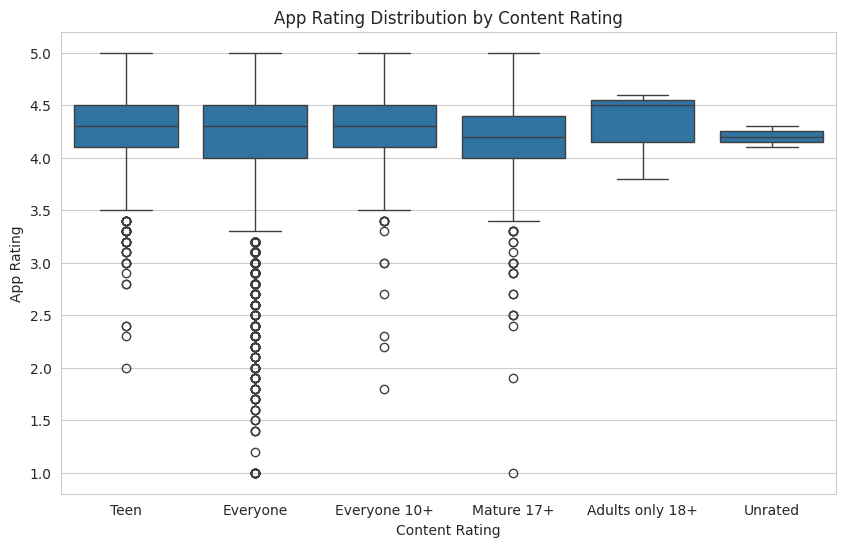

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Content Rating', y='Rating', data=df)
plt.title('App Rating Distribution by Content Rating')
plt.ylabel('App Rating')
plt.xlabel('Content Rating')
plt.show()

5. Genres with the most apps with over 1 million installs

In [42]:
df_high_installs = df[df['Installs'] > 1_000_000]
genre_counts = df_high_installs.groupby('Genres').size().sort_values(ascending=False).head(5)
print(genre_counts.to_string())

Genres
Tools            173
Action           128
Photography      124
Communication     99
Productivity      91


7. Impact of app size on the number of installs

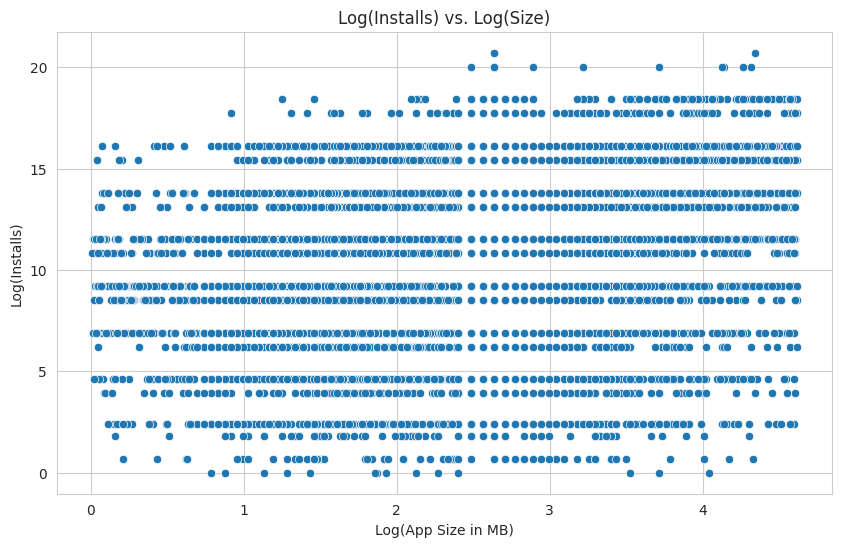

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(df['Size']), y='Installs_Log', data=df)
plt.title('Log(Installs) vs. Log(Size)')
plt.xlabel('Log(App Size in MB)')
plt.ylabel('Log(Installs)')
plt.show()

8. Apps with the highest number of reviews, and their ratings

In [44]:
top_reviews = df.sort_values(by='Reviews', ascending=False).head(5)
print(top_reviews[['App', 'Reviews', 'Rating', 'Installs']].to_string(index=False))

                                     App  Reviews  Rating   Installs
                                Facebook 78158306     4.1 1000000000
                      WhatsApp Messenger 69119316     4.4 1000000000
                               Instagram 66577446     4.5 1000000000
Messenger – Text and Video Chat for Free 56646578     4.0 1000000000
                          Clash of Clans 44893888     4.6  100000000


9. Content rating distribution: Free vs Paid

In [45]:
content_crosstab = pd.crosstab(df['Content Rating'], df['Type'], normalize='index').mul(100).round(1)
print(content_crosstab.to_string())

Type              Free  Paid
Content Rating              
Adults only 18+  100.0   0.0
Everyone          91.8   8.2
Everyone 10+      90.3   9.7
Mature 17+        95.4   4.6
Teen              95.0   5.0
Unrated          100.0   0.0


10. Top 5 categories with the most installs

In [46]:
total_installs = df.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(5)
print(total_installs.to_string())

Category
GAME             13457924415
COMMUNICATION    11038276251
TOOLS             8102271905
FAMILY            6227482405
PRODUCTIVITY      5793091369


**Advanced Level Question**
1. Top 10 apps with the highest ratings, reviews, and installs comparison

In [47]:
top_rated_apps = df[df['Rating'] == 5.0].sort_values(by=['Reviews', 'Installs'], ascending=False).head(10)

print(top_rated_apps[['App', 'Rating', 'Reviews', 'Installs']].to_string(index=False))

                                              App  Rating  Reviews  Installs
                                       Ríos de Fe     5.0      141      1000
FD Calculator (EMI, SIP, RD & Loan Eligilibility)     5.0      104      1000
                                       Oración CX     5.0      103      5000
                   Barisal University App-BU Face     5.0      100      1000
                                       Master E.K     5.0       90      1000
                                          CL REPL     5.0       47      1000
                                           AJ Cam     5.0       44       100
                      CS & IT Interview Questions     5.0       43      1000
                                          Ek Vote     5.0       43       500
 AI Today : Artificial Intelligence News & AI 101     5.0       43       100


2. Analyze the trend of app updates over time

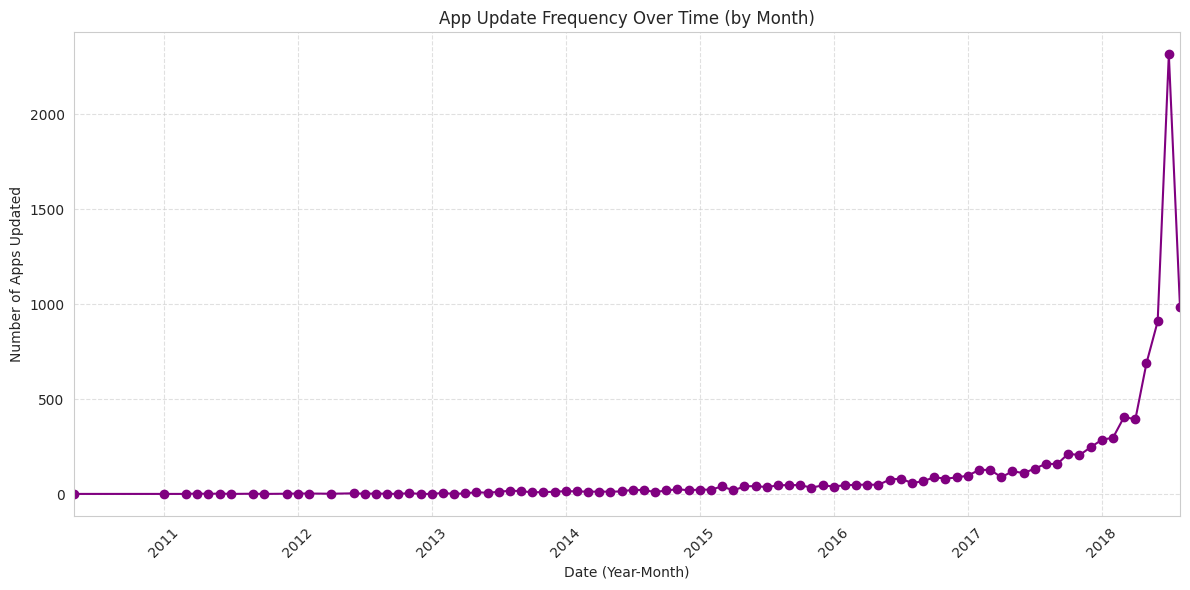

In [48]:
df['Update_Month_Year'] = df['Last Updated'].dt.to_period('M')

update_frequency = df.groupby('Update_Month_Year').size()

plt.figure(figsize=(12, 6))
update_frequency.plot(kind='line', marker='o', color='purple')
plt.title('App Update Frequency Over Time (by Month)')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Number of Apps Updated')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

3. How average rating changes with the number of installs

In [49]:
df['Installs'] = df['Installs'].astype(int)
install_bins = [0, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, df['Installs'].max() + 1]
install_labels = ['<100', '100-1K', '1K-10K', '10K-100K', '100K-1M', '1M-10M', '10M-100M', '100M+']

df.loc[:, 'Installs_Bin'] = pd.cut(df['Installs'], bins=install_bins, labels=install_labels, right=False, include_lowest=True)

avg_rating_by_bin = df.groupby('Installs_Bin', observed=True)['Rating'].mean().sort_values(ascending=False)
print(avg_rating_by_bin.to_string())
print("Insight: See if quality (rating) degrades or improves as an app scales.")

Installs_Bin
100M+       4.370386
<100        4.345273
10M-100M    4.304557
100-1K      4.295077
1M-10M      4.220168
100K-1M     4.134344
1K-10K      4.092308
10K-100K    4.047460
Insight: See if quality (rating) degrades or improves as an app scales.


5. Relationship between app genre and user ratings

In [50]:
df.loc[:, 'Primary_Genre'] = df['Genres'].apply(lambda x: x.split(';')[0])

genre_ratings = df.groupby('Primary_Genre')['Rating'].agg(['count', 'mean', 'median'])
genre_ratings = genre_ratings[genre_ratings['count'] >= 50].sort_values(by='mean', ascending=False).head(10)

print("Top 10 Primary Genres by Average Rating (Min 50 Apps):")
print(genre_ratings.to_string())
print("Insight: Focusing on these genres might lead to higher initial user satisfaction.")

df.drop(columns=['Update_Month_Year', 'Installs_Bin', 'Primary_Genre'], inplace=True, errors='ignore')

Top 10 Primary Genres by Average Rating (Min 50 Apps):
                   count      mean  median
Primary_Genre                             
Events                64  4.395313    4.30
Art & Design          64  4.365625    4.40
Puzzle               141  4.363830    4.30
Books & Reference    224  4.333036    4.30
Personalization      374  4.324866    4.30
Parenting             60  4.300000    4.35
Education            579  4.294473    4.30
Board                 60  4.291667    4.30
Beauty                53  4.283019    4.30
Arcade               199  4.279397    4.30
Insight: Focusing on these genres might lead to higher initial user satisfaction.
